In [1]:
import warnings
import sys
import os
import pickle
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from pathlib import Path
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error, mean_squared_log_error
from lightgbm import LGBMRegressor
from ucimlrepo import fetch_ucirepo 
from pymfe.mfe import MFE
from sklearn.tree import DecisionTreeRegressor

from artifact.util import df_data
from artifact.pipeline_components import pipeline_calculate_biasScore
from artifact.sensitive_ssr import CatagoricalSubspace

C:\Users\k_dos\Desktop\Metalearning-Bias-Detection\meta.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train meta-learners from meta-dataset

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness","group_fairness"]
targets=['disparate_parity', 'equal_opportunity', 'group_fairness']
target_names = ['Disparate Parity', 'Equal Opportunity', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict_w = dict(zip(targets, target_names_w))
target_names_dict = dict(zip(targets, target_names))

In [123]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
Y=df[targets]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

absolute_result_path="experiment_result/Q5_absolute_result_3bs.csv"
normal_result_path="experiment_result/Q5_normal_result_3bs.csv"

absolute_result,normal_result=pd.DataFrame(),pd.DataFrame()
if Path(absolute_result_path).is_file():
    absolute_result=pd.read_csv(absolute_result_path,header=0,index_col=0)
if Path(normal_result_path).is_file():
    normal_result=pd.read_csv(normal_result_path,header=0,index_col=0)

## Train independent predictors

In [124]:
# lightgbm_parameters={
#     "n_estimators":[50,100,150,200,250,300,400,500,750,1000],
#     "max_depth":[2,3,5,7,10,15,20, 30],
#     "learning_rate":[0.1],
# }
# gridSearch_CVsettings={
#     "n_splits":3,
#     "shuffle":True,
#     "random_state":700
# }

# indie_models={}
# for target in tqdm(targets,desc="indie_model"):
#     base_model=LGBMRegressor(objective="regression", n_jobs=2, random_state =700, device_type ="cpu",verbosity=-1)
#     gridSearch_model=GridSearchCV(base_model,lightgbm_parameters,cv=KFold(**gridSearch_CVsettings),scoring="neg_mean_squared_error", n_jobs=5)
#     gridSearch_model.fit(X_train,Y_train[target])
#     indie_models[target]=gridSearch_model

# with open("case_study_artifact/models/indie_models_3bs.pkl","wb") as file:
#     pickle.dump(indie_models,file)

indie_model: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [04:06<00:00, 82.18s/it]


## Train individual chain model

In [125]:
lightgbm_parameters={
    "n_estimators":[50,100,150,200,250,300,400,500,750,1000],
    "max_depth":[2,3,5,7,10,15,20, 30],
    "learning_rate":[0.1],
}

In [126]:
class CVLightGBM:
    def __init__(self):
        self.best_params = {}

    def fit(self, X, y, **kwargs):
        base_model=LGBMRegressor(objective="regression", n_jobs=2, random_state =700, device_type ="cpu",verbosity=-1)
        self.model=GridSearchCV(base_model, param_grid=lightgbm_parameters, cv=KFold(n_splits=3, shuffle=True, random_state=700), 
                                scoring="neg_root_mean_squared_error", n_jobs=5)
        self.model.fit(X, y)
        self.best_params = self.model.best_params_

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=False):
        return self.best_params

In [127]:
# with individual parameter tuning for each model in the chain
for i, order in enumerate(list(itertools.permutations(range(len(targets))))):
    chain = [targets[i] for i in order]

    base_model=CVLightGBM()
    indie_chain_model=RegressorChain(base_estimator=base_model, order=order, random_state=1000)
    indie_chain_model.fit(X_train, Y_train)
    for j in range(3):
        print(i, ' -- ', chain[j], ' -- ', indie_chain_model.estimators_[j].best_params)
    
    with open(f"case_study_artifact/models/indie_chain_models_{i}_paramstuned_indiv.pkl","wb") as file:
        pickle.dump((chain,indie_chain_model),file)
    print(chain, order, 'completed:', root_mean_squared_error(Y_test, indie_chain_model.predict(X_test)))

0  --  disparate_parity  --  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0  --  equal_opportunity  --  {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
0  --  group_fairness  --  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 750}
['disparate_parity', 'equal_opportunity', 'group_fairness'] (0, 1, 2) completed: 0.12418159214254065
1  --  disparate_parity  --  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
1  --  group_fairness  --  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
1  --  equal_opportunity  --  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
['disparate_parity', 'group_fairness', 'equal_opportunity'] (0, 2, 1) completed: 0.12425028214242391
2  --  equal_opportunity  --  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
2  --  disparate_parity  --  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 50}
2  --  group_fairness  --  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 750}

In [180]:
best_chain_index = 5

In [33]:
lightgbm_parameters={
    "base_estimator__n_estimators":range(50,300,50),
    "base_estimator__max_depth":[5,10,20,30,40],
    "base_estimator__learning_rate":[0.1],
}
gridSearch_CVsettings={
    "n_splits":2,
    "shuffle":True,
    "random_state":700
}

In [34]:
# with parameter tuning
for i, order in enumerate(list(itertools.permutations(range(len(targets))))):
    chain = [targets[i] for i in order]

    base_model=LGBMRegressor(objective="regression", n_jobs=2, random_state =700, device_type ="gpu",verbosity=-1)
    indie_chain_model=GridSearchCV(RegressorChain(base_estimator=base_model, order=order, random_state=1000),
                                   lightgbm_parameters,cv=KFold(**gridSearch_CVsettings),scoring="neg_root_mean_squared_error", n_jobs=5)
    indie_chain_model.fit(X_train, Y_train)
    print(i, ' -- ', indie_chain_model.best_params_)
    
    with open(f"case_study_artifact/models/indie_chain_models_{i}_paramstuned.pkl","wb") as file:
        pickle.dump((chain,indie_chain_model.best_estimator_),file)
    print(chain, order, 'completed:', root_mean_squared_error(Y_test, indie_chain_model.best_estimator_.predict(X_test)))

0  --  {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 40, 'base_estimator__n_estimators': 100}
['disparate_parity', 'equal_opportunity', 'group_fairness'] (0, 1, 2) completed: 0.12920304850591666
1  --  {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 5, 'base_estimator__n_estimators': 200}
['disparate_parity', 'group_fairness', 'equal_opportunity'] (0, 2, 1) completed: 0.13028545961646512
2  --  {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 5, 'base_estimator__n_estimators': 200}
['equal_opportunity', 'disparate_parity', 'group_fairness'] (1, 0, 2) completed: 0.12964970743499915
3  --  {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 40, 'base_estimator__n_estimators': 100}
['equal_opportunity', 'group_fairness', 'disparate_parity'] (1, 2, 0) completed: 0.12979181499614995
4  --  {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 10, 'base_estimator__n_estimators': 100}
['group_fairness',

In [35]:
# with fixed parameters
best_params = {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}
for i, order in enumerate(list(itertools.permutations(range(len(targets))))):
    chain = [targets[i] for i in order]
    base_model=LGBMRegressor(objective="regression", n_jobs=2, random_state =700, device_type ="gpu",verbosity=-1,**best_params)

    indie_chain_model=RegressorChain(base_estimator=base_model, order=order, random_state=1000)
    indie_chain_model.fit(X_train,Y_train)
    
    with open(f"case_study_artifact/models/indie_chain_models_{i}.pkl","wb") as file:
        pickle.dump((chain,indie_chain_model),file)
    print(chain, order, 'completed:', root_mean_squared_error(Y_test, indie_chain_model.predict(X_test)))

['disparate_parity', 'equal_opportunity', 'group_fairness'] (0, 1, 2) completed: 0.13097371757495616
['disparate_parity', 'group_fairness', 'equal_opportunity'] (0, 2, 1) completed: 0.13063220161647027
['equal_opportunity', 'disparate_parity', 'group_fairness'] (1, 0, 2) completed: 0.13008290624923527
['equal_opportunity', 'group_fairness', 'disparate_parity'] (1, 2, 0) completed: 0.12955605886450827
['group_fairness', 'disparate_parity', 'equal_opportunity'] (2, 0, 1) completed: 0.12898744033193568
['group_fairness', 'equal_opportunity', 'disparate_parity'] (2, 1, 0) completed: 0.1288619767190677


In [36]:
best_chain = ['group_fairness', 'equal_opportunity', 'disparate_parity']
best_order = [2,1,0]
best_chain_index = 5

## Ensemble Model

In [128]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [129]:
models = {}
for i in range(6):
    with open(f"case_study_artifact/models/indie_chain_models_{i}.pkl","rb") as file:
        chain, model=pickle.load(file)
        models[tuple(chain)] = model

In [222]:
class AveragingModel:
    def __init__(self, appendix=''):
        self.chains = []
        self.orders = []
        for i, order in enumerate(itertools.permutations(range(len(targets)))):
            with open(f"case_study_artifact/models/indie_chain_models_{i}{appendix}.pkl", "rb") as file:
                _, model = pickle.load(file)
            self.chains.append(model)
            self.orders.append(order)

    def fit(self, X_val, Y_val):
        pass
    
    def predict(self, X):
        # chain_predictions = np.empty((len(targets), 6, len(X)))
        # for i, model in enumerate(self.chains):
        #     predictions = model.predict(X)
        #     for target_idx, pred in zip(self.orders[i], predictions.T):
        #         chain_predictions[target_idx] = pred
        # avg_preds = np.mean(np.array(chain_predictions), axis=1)
        preds = []
        for model in self.chains:
            preds.append(model.predict(X))
        return np.average(np.array(preds), axis=0)

class EnsembleModel:
    def __init__(self, appendix=''):
        self.chains = []
        for i, order in enumerate(itertools.permutations(range(len(targets)))):
            with open(f"case_study_artifact/models/indie_chain_models_{i}{appendix}.pkl", "rb") as file:
                _, model = pickle.load(file)
            self.chains.append(model)
        self.model = None
        self.param_grid = {'max_depth': [2, 3, 5, 7, 10, None]}

    def get_chain_preds(self, X):
        chain_predictions = []
        for i, model in enumerate(self.chains):
            chain_predictions.append(model.predict(X))
        return np.concatenate(chain_predictions, axis=1)

    def fit(self, X_val, Y_val):
        chain_predictions = self.get_chain_preds(X_val)
        grid_search = GridSearchCV(DecisionTreeRegressor(), self.param_grid, 
                                   cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(chain_predictions, Y_val)
        self.max_depth = grid_search.best_params_['max_depth']
        self.model = DecisionTreeRegressor(max_depth=self.max_depth)
        self.model.fit(chain_predictions, Y_val)
    
    def predict(self, X):
        chain_predictions = self.get_chain_preds(X)
        return self.model.predict(chain_predictions)

# Load Models from Artifcts

In [223]:
with open("case_study_artifact/models/indie_models_3bs.pkl","rb") as file:
    models_independent = pickle.load(file)
preds = np.empty((len(X_test), 0))
for t in targets:
    preds = np.column_stack((preds, models_independent[t].predict(X_test)))
print('IndividualModels: ', root_mean_squared_error(Y_test, preds))

with open(f"case_study_artifact/models/indie_chain_models_{best_chain_index}_paramstuned_indiv.pkl", "rb") as file:
    _, model_bestchain = pickle.load(file)
print('BestChain: ', root_mean_squared_error(Y_test, model_bestchain.predict(X_test)))

# model_avg = AveragingModel()
# model_avg.fit(X_val, Y_val)
# print('AveragingModel: ', root_mean_squared_error(Y_test, model_avg.predict(X_test)))

# model_ens = EnsembleModel()
# model_ens.fit(X_val, Y_val)
# print('EnsembleModel: ', root_mean_squared_error(Y_test, model_ens.predict(X_test)))

model_avg = AveragingModel(appendix='_paramstuned_indiv')
model_avg.fit(X_val, Y_val)
print('AveragingModel individually tuned: ', root_mean_squared_error(Y_test, model_avg.predict(X_test)))

# model_ens = EnsembleModel(appendix='_paramstuned_indiv')
# model_ens.fit(X_val, Y_val)
# print('EnsembleModel individually tuned: ', root_mean_squared_error(Y_test, model_ens.predict(X_test)))

IndividualModels:  0.12225530205953446
BestChain:  0.12273849816286696
AveragingModel individually tuned:  0.12238699891609484


# Case 1 Adult Dataset

In [267]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
adult_X = adult.data.features 
adult_y = adult.data.targets 

missingEntry_X_index=adult_X[adult_X.isna().any(axis=1)].index
missingEntry_Y_index=adult_y[adult_y.isna().any(axis=1)].index
missingEntry_index=np.hstack([missingEntry_X_index, missingEntry_Y_index])

adult_X=adult_X.drop(missingEntry_index)
adult_y=adult_y.drop(missingEntry_index)

In [268]:
# #Calculate Meta-feature
# mfe = MFE(groups=["complexity",'landmarking','info-theory',"model-based"],
#           summary=["mean"],measure_time="total_summ",suppress_warnings=True,random_state=100)
# mfe.fit(adult_X.to_numpy(),adult_y.to_numpy(),verbose=True,suppress_warnings=True)
# meta_features=mfe.extract()
# meta_features={meta_features[0][i]:meta_features[1][i] for i in range(len(meta_features[0]))}
# display(meta_features)
# meta_features=pd.DataFrame([meta_features])
# meta_features=meta_features.replace(np.nan,0)
# meta_features.to_csv("case_study_artifact/dataset/metafeatures/adult_metafeature.csv")

In [269]:
meta_features=pd.read_csv("case_study_artifact/dataset/metafeatures/adult_metafeature.csv",index_col=0)
meta_features

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,random_node.mean,t1,t2,t3,t4,tree_depth.mean,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean
0,0.042513,2.237972,0.519099,0.849581,0.203535,0.026963,1.699162,0.519642,0.916617,0.397094,...,0.519099,0.721005,0.002121,0.000021,0.009901,27.966587,0.011284,0.000445,0.009901,0.519099


## Manually Label Sensisitive Subspace and Calculate Bias Metrics

In [270]:
adult_X=adult_X.copy()
adult_y=adult_y.copy()
adult_categorical_feature=adult_X.columns[~adult_X.applymap(lambda x: isinstance(x, (int, float))).all()] 

adult_encoders={}
for cat in adult_categorical_feature:
    label_encoder=LabelEncoder()
    adult_X[cat]=label_encoder.fit_transform(adult_X[cat])
    adult_encoders[cat]=label_encoder

label_encoder=LabelEncoder()
adult_y["income"]=label_encoder.fit_transform(adult_y["income"])
adult_df_data=df_data(adult_X,adult_y["income"],[">50K.",">50K"],label_encoder)

def race_predicate(df):
    return ~df["race"].isin(adult_encoders["race"].transform(["White"]))

def sex_predicate(df):
    return ~df["sex"].isin(adult_encoders["sex"].transform(["Male"]))

def age_predicate(df):
    return df["age"]>65

race_subspace=CatagoricalSubspace([race_predicate])
sex_subspace=CatagoricalSubspace([sex_predicate])
age_subspace=CatagoricalSubspace([age_predicate])

adult_sensitive_subspaces=[race_subspace,sex_subspace,age_subspace]

In [271]:
res_exp=pipeline_calculate_biasScore({"landmarking_random_state":100},adult_df_data,adult_sensitive_subspaces)
res_exp.update({"Model":"Expert Knowledge","Dataset":"Adult"})
res_exp=pd.DataFrame([res_exp])[targets+['Model', 'Dataset']]

In [274]:
def get_results(meta_features, dataset_name, df_exp):
    res_single={"Model":"Single-Target","Dataset":dataset_name}
    for bias_metric, predictor in models_independent.items():
        res_single[bias_metric]=predictor.predict(meta_features)[0]
    res_single=pd.DataFrame([res_single]) 

    res_bestchain={"Model":"Best Chain","Dataset":dataset_name}
    res_bestchain.update(dict(zip(targets,model_bestchain.predict(meta_features)[0])))
    res_bestchain=pd.DataFrame([res_bestchain])

    res_avg={"Model":"Ensemble","Dataset":dataset_name}
    res_avg.update(dict(zip(targets,model_avg.predict(meta_features)[0])))
    res_avg=pd.DataFrame([res_avg])

    # res_ens={"Model":"Ensemble","Dataset":dataset_name}
    # res_ens.update(dict(zip(targets,model_ens.predict(meta_features)[0])))
    # res_ens=pd.DataFrame([res_ens])

    res_adult=pd.concat([res_single,res_bestchain,res_avg,df_exp]).reset_index(drop=True)
    return res_adult

In [275]:
res_adult = get_results(meta_features, 'Adult', res_exp)
res_adult.to_csv("experiment_result/Q5_absolute_result_3bs.csv")
res_adult

,Model,Dataset,disparate_parity,equal_opportunity,group_fairness
0,Single-Target,Adult,0.151569,0.220224,0.538851
1,Best Chain,Adult,0.173074,0.256375,0.538851
2,Ensemble,Adult,0.157563,0.209034,0.559441
3,Expert Knowledge,Adult,0.113747,0.049327,0.399480


# Case 2 OULAD

In [276]:
oulad_df=pd.read_csv("case_study_artifact/dataset/original/OULAD_data.csv")
oulad_X=oulad_df.drop(["final_result","id_student"],axis=1)
oulad_y=oulad_df[["final_result"]]

missingEntry_X_index=oulad_X[oulad_X.isna().any(axis=1)].index
missingEntry_Y_index=oulad_y[oulad_y.isna().any(axis=1)].index
missingEntry_index=np.hstack([missingEntry_X_index, missingEntry_Y_index])

oulad_X=oulad_X.drop(missingEntry_index)
oulad_y=oulad_y.drop(missingEntry_index)

In [277]:
# #Calculate Meta-feature
# mfe = MFE(groups=["complexity",'landmarking','info-theory',"model-based"],
#           summary=["mean"],measure_time="total_summ",suppress_warnings=True,random_state=100)
# mfe.fit(oulad_X.to_numpy(),oulad_y.to_numpy(),verbose=True,suppress_warnings=True)
# meta_features=mfe.extract()
# meta_features={meta_features[0][i]:meta_features[1][i] for i in range(len(meta_features[0]))}
# display(meta_features)
# meta_features=pd.DataFrame([meta_features])
# meta_features=meta_features.replace(np.nan,0)
# meta_features.to_csv("case_study_artifact/dataset/metafeatures/oulad_metafeature.csv")

In [278]:
meta_features=pd.read_csv("case_study_artifact/dataset/metafeatures/oulad_metafeature.csv",index_col=0)
meta_features

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,random_node.mean,t1,t2,t3,t4,tree_depth.mean,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean
0,0.012813,1.804666,0.410903,0.923923,0.075154,0.005842,1.847847,0.595543,0.942496,0.357346,...,0.349341,0.485166,0.001302,0.000032,0.02439,21.277351,0.025551,0.000566,0.02439,0.375993


## Manually Label Sensisitive Subspace and Calculate Bias Metrics

In [279]:
oulad_X=oulad_X.copy()
oulad_y=oulad_y.copy()
oulad_categorical_feature=oulad_X.columns[~oulad_X.applymap(lambda x: isinstance(x, (int, float))).all()] 

oulad_encoders={}
for cat in oulad_categorical_feature:
    label_encoder=LabelEncoder()
    oulad_X[cat]=label_encoder.fit_transform(oulad_X[cat])
    oulad_encoders[cat]=label_encoder

label_encoder=LabelEncoder()
oulad_y["final_result"]=label_encoder.fit_transform(oulad_y["final_result"])
oulad_df_data=df_data(oulad_X,oulad_y["final_result"],["Distinction","Pass"],label_encoder)

def gender_predicate(df):
    return ~df["gender"].isin(oulad_encoders["gender"].transform(["M"]))

def age_predicate(df):
    return df["age_band"].isin(oulad_encoders["age_band"].transform(["55<="]))

def disability_predicate(df):
    return df["disability"].isin(oulad_encoders["disability"].transform(["Y"]))


gender_subspace=CatagoricalSubspace([gender_predicate])
age_subspace=CatagoricalSubspace([age_predicate])
disability_subspace=CatagoricalSubspace([disability_predicate])

oulad_sensitive_subspaces=[gender_subspace,age_subspace,disability_subspace]

In [280]:
res_exp=pipeline_calculate_biasScore({"landmarking_random_state":100},oulad_df_data,oulad_sensitive_subspaces)
res_exp.update({"Model":"Expert Knowledge","Dataset":"OULAD"})
res_exp=pd.DataFrame([res_exp])[targets+['Model', 'Dataset']]

In [281]:
res_oulad = get_results(meta_features, 'OULAD', res_exp)
res_all = pd.read_csv("experiment_result/Q5_absolute_result_3bs.csv", index_col=0)
res_all=pd.concat([res_all,res_oulad]).reset_index(drop=True)
res_all.to_csv("experiment_result/Q5_absolute_result_3bs.csv")
res_oulad

,Model,Dataset,disparate_parity,equal_opportunity,group_fairness
0,Single-Target,OULAD,0.224642,0.164227,0.619722
1,Best Chain,OULAD,0.138410,0.219720,0.619722
2,Ensemble,OULAD,0.179155,0.209411,0.659659
3,Expert Knowledge,OULAD,0.127212,0.057049,0.450491


# Case 3 Materials and their Mechanical Properties

In [282]:
material_df=pd.read_csv("case_study_artifact/dataset/original/material.csv")
material_X=material_df.drop(["Use","Material"],axis=1)
material_y=material_df[["Use"]]

missingEntry_X_index=material_X[material_X.isna().any(axis=1)].index
missingEntry_Y_index=material_y[material_y.isna().any(axis=1)].index
missingEntry_index=np.hstack([missingEntry_X_index, missingEntry_Y_index])

material_X=material_X.drop(missingEntry_index)
material_y=material_y.drop(missingEntry_index)

In [283]:
# #Calculate Meta-feature
# mfe = MFE(groups=["complexity",'landmarking','info-theory',"model-based"],
#           summary=["mean"],measure_time="total_summ",suppress_warnings=True,random_state=100)
# mfe.fit(material_X.to_numpy(),material_y.to_numpy(),verbose=True,suppress_warnings=True)
# meta_features=mfe.extract()
# meta_features={meta_features[0][i]:meta_features[1][i] for i in range(len(meta_features[0]))}
# display(meta_features)
# meta_features=pd.DataFrame([meta_features])
# meta_features=meta_features.replace(np.nan,0)
# meta_features.to_csv("case_study_artifact/dataset/metafeatures/material_metafeature.csv")

In [284]:
meta_features=pd.read_csv("case_study_artifact/dataset/metafeatures/material_metafeature.csv",index_col=0)
meta_features

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,random_node.mean,t1,t2,t3,t4,tree_depth.mean,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean
0,0.306802,2.588422,0.913019,0.426324,0.811171,0.027711,0.426324,0.225117,0.835305,0.781733,...,0.913019,0.030928,0.003866,0.001289,0.333333,3.230769,0.133236,0.28125,0.166667,0.913019


In [285]:
res_materials = get_results(meta_features, 'Materials', None)
res_all = pd.read_csv("experiment_result/Q5_absolute_result_3bs.csv", index_col=0)
res_all=pd.concat([res_all,res_materials]).reset_index(drop=True)
res_all.to_csv("experiment_result/Q5_absolute_result_3bs.csv")
res_materials

,Model,Dataset,disparate_parity,equal_opportunity,group_fairness
0,Single-Target,Materials,0.151151,0.203184,0.055478
1,Best Chain,Materials,0.117246,0.171906,0.055478
2,Ensemble,Materials,0.135601,0.181288,0.043336


# Case 4 COMPAS

In [286]:
COMPAS_df=pd.read_csv("case_study_artifact/dataset/original/compas-scores-two-years.csv")
COMPAS_X=COMPAS_df.drop(["two_year_recid","id","name","first","last","compas_screening_date","screening_date","v_screening_date"],axis=1)
COMPAS_y=COMPAS_df[["two_year_recid"]]

missing_column=COMPAS_X.columns[COMPAS_X.isna().any()]

COMPAS_X=COMPAS_X.drop(missing_column,axis=1)

In [287]:
# #Calculate Meta-feature
# mfe = MFE(groups=["complexity",'landmarking','info-theory',"model-based"],
#           summary=["mean"],measure_time="total_summ",suppress_warnings=True,random_state=100)
# mfe.fit(COMPAS_X.to_numpy(),COMPAS_y.to_numpy(),verbose=True,suppress_warnings=True)
# meta_features=mfe.extract()
# meta_features={meta_features[0][i]:meta_features[1][i] for i in range(len(meta_features[0]))}
# display(meta_features)
# meta_features=pd.DataFrame([meta_features])
# meta_features=meta_features.replace(np.nan,0)
# meta_features.to_csv("case_study_artifact/dataset/metafeatures/COMPAS_metafeature.csv")

In [288]:
meta_features=pd.read_csv("case_study_artifact/dataset/metafeatures/COMPAS_metafeature.csv",index_col=0)
meta_features

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,random_node.mean,t1,t2,t3,t4,tree_depth.mean,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean
0,0.114813,2.118067,0.969502,0.992962,0.019294,0.127871,0.992962,0.420308,0.845406,0.969502,...,0.549348,0.528971,0.759495,0.000139,0.000183,12.818898,0.027105,0.045593,0.000183,0.555167


## Manually Label Sensisitive Subspace and Calculate Bias Metrics

In [289]:
COMPAS_X=COMPAS_X.copy()
COMPAS_y=COMPAS_y.copy()
COMPAS_categorical_feature=COMPAS_X.columns[~COMPAS_X.applymap(lambda x: isinstance(x, (int, float))).all()] 

COMPAS_encoders={}
for cat in COMPAS_categorical_feature:
    label_encoder=LabelEncoder()
    COMPAS_X[cat]=label_encoder.fit_transform(COMPAS_X[cat])
    COMPAS_encoders[cat]=label_encoder

COMPAS_df_data=df_data(COMPAS_X,COMPAS_y["two_year_recid"],[1])

def sex_predicate(df):
    return ~df["sex"].isin(COMPAS_encoders["sex"].transform(["Male"]))

def race_predicate(df):
    return ~df["race"].isin(COMPAS_encoders["race"].transform(["Caucasian"]))

def age_predicate(df):
    return df["age_cat"].isin(COMPAS_encoders["age_cat"].transform(["Greater than 45"]))


sex_subspace=CatagoricalSubspace([sex_predicate])
race_subspace=CatagoricalSubspace([race_predicate])
age_subspace=CatagoricalSubspace([age_predicate])

COMPAS_sensitive_subspaces=[sex_subspace,race_subspace,age_subspace]

In [290]:
res_exp=pipeline_calculate_biasScore({"landmarking_random_state":100},COMPAS_df_data,COMPAS_sensitive_subspaces)
res_exp.update({"Model":"Expert Knowledge","Dataset":"COMPAS"})
res_exp=pd.DataFrame([res_exp])[targets+['Model', 'Dataset']]

In [291]:
res_compas = get_results(meta_features, 'COMPAS', res_exp)
res_all = pd.read_csv("experiment_result/Q5_absolute_result_3bs.csv", index_col=0)
res_all=pd.concat([res_all,res_compas]).reset_index(drop=True)
res_all.to_csv("experiment_result/Q5_absolute_result_3bs.csv")
res_compas

,Model,Dataset,disparate_parity,equal_opportunity,group_fairness
0,Single-Target,COMPAS,0.211130,0.167353,0.151924
1,Best Chain,COMPAS,0.445797,0.294414,0.151924
2,Ensemble,COMPAS,0.312120,0.180946,0.148423
3,Expert Knowledge,COMPAS,0.091886,0.014374,0.015453


# Case 5 Diabetes

In [292]:
diabetes_repo = fetch_ucirepo(id=296) 

Diabetes_df=pd.DataFrame(diabetes_repo.data.original)
Diabetes_X=Diabetes_df.drop(["encounter_id","patient_nbr","readmitted"],axis=1)
Diabetes_y=Diabetes_df[["readmitted"]]

missing_column=Diabetes_df.columns[Diabetes_df.isna().sum()>=10000]
Diabetes_X=Diabetes_X.drop(missing_column,axis=1)

missingEntry_X_index=Diabetes_X[Diabetes_X.isna().any(axis=1)].index
missingEntry_Y_index=Diabetes_y[Diabetes_y.isna().any(axis=1)].index
missingEntry_index=np.hstack([missingEntry_X_index, missingEntry_Y_index])

Diabetes_X=Diabetes_X.drop(missingEntry_index)
Diabetes_y=Diabetes_y.drop(missingEntry_index)

In [293]:
np.random.seed(10000)
small_Diabetes_index=np.random.choice(Diabetes_X.index.to_numpy(),20000) 
small_Diabetes_X=Diabetes_X.loc[small_Diabetes_index].reset_index(drop=True)
small_Daibetes_y=Diabetes_y.loc[small_Diabetes_index].reset_index(drop=True)

In [294]:
# #Calculate Meta-feature
# mfe = MFE(groups=["complexity",'landmarking','info-theory',"model-based"],
#           summary=["mean"],measure_time="total_summ",suppress_warnings=True,random_state=100)
# mfe.fit(small_Diabetes_X.to_numpy(),small_Daibetes_y.to_numpy(),verbose=True,suppress_warnings=True)
# meta_features=mfe.extract()
# meta_features={meta_features[0][i]:meta_features[1][i] for i in range(len(meta_features[0]))}
# display(meta_features)
# meta_features=pd.DataFrame([meta_features])
# meta_features=meta_features.replace(np.nan,0)
# meta_features.to_csv("case_study_artifact/dataset/metafeatures/Diabetes_metafeature.csv")

In [295]:
meta_features=pd.read_csv("case_study_artifact/dataset/metafeatures/Diabetes_metafeature.csv",index_col=0)
meta_features

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,random_node.mean,t1,t2,t3,t4,tree_depth.mean,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean
0,0.087515,1.340457,0.5565,0.862106,0.176972,0.096867,1.366405,0.565802,0.911977,0.414,...,0.5349,0.864,0.08555,0.0002,0.002338,30.229662,0.007872,0.001386,0.000584,0.535


## Manually Label Sensisitive Subspace and Calculate Bias Metrics

In [296]:
small_Diabetes_X=small_Diabetes_X.copy()
small_Daibetes_y=small_Daibetes_y.copy()
Diabetes_categorical_feature=Diabetes_X.columns[~Diabetes_X.applymap(lambda x: isinstance(x, (int, float))).all()] 

Diabetes_encoders={}
for cat in Diabetes_categorical_feature:
    label_encoder=LabelEncoder()
    small_Diabetes_X[cat]=label_encoder.fit_transform(small_Diabetes_X[cat])
    Diabetes_encoders[cat]=label_encoder

label_encoder=LabelEncoder()
small_Daibetes_y["readmitted"]=label_encoder.fit_transform(small_Daibetes_y["readmitted"])

Diabetes_df_data=df_data(small_Diabetes_X,small_Daibetes_y["readmitted"],[">30","<30"],label_encoder)

def race_predicate(df):
    return ~df["race"].isin(Diabetes_encoders["race"].transform(["Caucasian"]))

def gender_predicate(df):
    return ~df["gender"].isin(Diabetes_encoders["gender"].transform(["Male"]))

def age_predicate(df):
    return df["age"].isin(Diabetes_encoders["age"].transform(['[60-70)', '[70-80)', '[80-90)', '[90-100)']))


race_subspace=CatagoricalSubspace([race_predicate])
gender_subspace=CatagoricalSubspace([gender_predicate])
age_subspace=CatagoricalSubspace([age_predicate])

Diabetes_sensitive_subspaces=[gender_subspace,race_subspace,age_subspace]

In [297]:
res_exp=pipeline_calculate_biasScore({"landmarking_random_state":100},Diabetes_df_data,Diabetes_sensitive_subspaces)
res_exp.update({"Model":"Expert Knowledge","Dataset":"Diabetes"})
res_exp=pd.DataFrame([res_exp])[targets+['Model', 'Dataset']]

In [298]:
res_diabetes = get_results(meta_features, 'Diabetes', res_exp)
res_all = pd.read_csv("experiment_result/Q5_absolute_result_3bs.csv", index_col=0)
res_all=pd.concat([res_all,res_diabetes]).reset_index(drop=True)
res_all.to_csv("experiment_result/Q5_absolute_result_3bs.csv")
res_diabetes

,Model,Dataset,disparate_parity,equal_opportunity,group_fairness
0,Single-Target,Diabetes,0.084323,0.255892,0.422732
1,Best Chain,Diabetes,0.180197,0.343247,0.422732
2,Ensemble,Diabetes,0.126501,0.250564,0.380705
3,Expert Knowledge,Diabetes,0.028343,0.038839,0.348910


# Case 6 German

In [299]:
germen_repo = fetch_ucirepo(id=144) 

germen_df=pd.DataFrame(germen_repo.data.original)

german_X=germen_df.drop(["class"],axis=1)
german_y=germen_df[["class"]]

missingEntry_X_index=german_X[german_X.isna().any(axis=1)].index
missingEntry_Y_index=german_y[german_y.isna().any(axis=1)].index
missingEntry_index=np.hstack([missingEntry_X_index, missingEntry_Y_index])

german_X=german_X.drop(missingEntry_index)
german_y=german_y.drop(missingEntry_index)

In [300]:
# #Calculate Meta-feature
# mfe = MFE(groups=["complexity",'landmarking','info-theory',"model-based"],
#           summary=["mean"],measure_time="total_summ",suppress_warnings=True,random_state=100)
# mfe.fit(german_X.to_numpy(),german_y.to_numpy(),verbose=True,suppress_warnings=True)
# meta_features=mfe.extract()
# meta_features={meta_features[0][i]:meta_features[1][i] for i in range(len(meta_features[0]))}
# display(meta_features)
# meta_features=pd.DataFrame([meta_features])
# meta_features=meta_features.replace(np.nan,0)
# meta_features.to_csv("case_study_artifact/dataset/metafeatures/german_metafeature.csv")

In [301]:
meta_features=pd.read_csv("case_study_artifact/dataset/metafeatures/german_metafeature.csv",index_col=0)
meta_features

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,random_node.mean,t1,t2,t3,t4,tree_depth.mean,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean
0,0.018832,1.653984,0.7,0.881291,0.275862,0.008087,0.881291,0.594466,0.877558,0.599,...,0.7,0.705,0.049,0.001,0.020408,9.301837,0.057559,0.031434,0.020408,0.7


## Manually Label Sensisitive Subspace and Calculate Bias Metrics

In [302]:
german_X=german_X.copy()
german_y=german_y.copy()
germen_categorical_feature=german_X.columns[~german_X.applymap(lambda x: isinstance(x, (int, float))).all()] 

germen_encoders={}
for cat in germen_categorical_feature:
    label_encoder=LabelEncoder()
    german_X[cat]=label_encoder.fit_transform(german_X[cat])
    germen_encoders[cat]=label_encoder

germen_df_data=df_data(german_X,german_y["class"],[1])

def marital_status_predicate(df):
    return df["Attribute9"].isin(germen_encoders["Attribute9"].transform(["A91","A92","A93"]))

def age_predicate(df):
    return df["Attribute13"]>65

def foreignality_predicate(df):
    return df["Attribute20"].isin(germen_encoders["Attribute20"].transform(['A201']))


marital_status_subspace=CatagoricalSubspace([marital_status_predicate])
age_subspace=CatagoricalSubspace([age_predicate])
foreignality_subspace=CatagoricalSubspace([foreignality_predicate])

germen_sensitive_subspaces=[marital_status_subspace,age_subspace,foreignality_subspace]

In [303]:
res_exp=pipeline_calculate_biasScore({"landmarking_random_state":100},germen_df_data,germen_sensitive_subspaces)
res_exp.update({"Model":"Expert Knowledge","Dataset":"German"})
res_exp=pd.DataFrame([res_exp])[targets+['Model', 'Dataset']]

In [304]:
res_german = get_results(meta_features, 'German', res_exp)
res_all = pd.read_csv("experiment_result/Q5_absolute_result_3bs.csv", index_col=0)
res_all=pd.concat([res_all,res_german]).reset_index(drop=True)
res_all.to_csv("experiment_result/Q5_absolute_result_3bs.csv")
res_german

,Model,Dataset,disparate_parity,equal_opportunity,group_fairness
0,Single-Target,German,0.138328,0.103887,0.119634
1,Best Chain,German,0.124399,0.177861,0.119634
2,Ensemble,German,0.127461,0.142906,0.110788
3,Expert Knowledge,German,0.445520,0.436790,0.160811


# Ploting

In [305]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

target_names = ['Group Size Disparity', 'Prevalence Disparity', 'Equal Opportunity', 
                'Disparate Parity', 'Individual Fairness', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict = dict(zip(bias_score_key, target_names))

In [306]:
absolute_result = pd.read_csv("experiment_result/Q5_absolute_result_3bs.csv")

absolute_result_items=pd.DataFrame()
for _,rows in absolute_result.iterrows():
    section_items=[]
    for bm in targets:
        section_items.append({
            "Dataset":rows["Dataset"],
            "Model":rows["Model"],
            "Target":bm,
            "(Predicted) Score":rows[bm]
        })
    absolute_result_items=pd.concat([absolute_result_items,pd.DataFrame(section_items)])

absolute_result_items['Target'] = absolute_result_items['Target'].replace(target_names_dict)
absolute_result_items

,Dataset,Model,Target,(Predicted) Score
0,Adult,Single-Target,Disparate Parity,0.151569
1,Adult,Single-Target,Equal Opportunity,0.220224
2,Adult,Single-Target,Group Fairness,0.538851
0,Adult,Best Chain,Disparate Parity,0.173074
1,Adult,Best Chain,Equal Opportunity,0.256375
...,...,...,...,...
1,German,Ensemble,Equal Opportunity,0.142906
2,German,Ensemble,Group Fairness,0.110788
0,German,Expert Knowledge,Disparate Parity,0.445520
1,German,Expert Knowledge,Equal Opportunity,0.436790


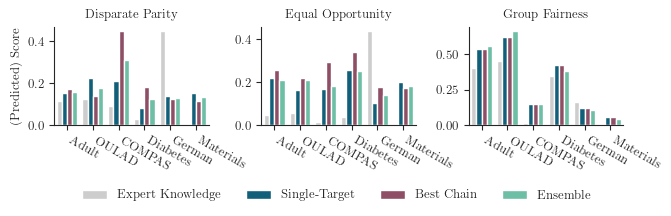

In [307]:
g = sns.catplot(
    data=absolute_result_items.reset_index(),
    x="Dataset", y="(Predicted) Score", hue="Model", col="Target",
    kind="bar", height=1.8, aspect=1.2, palette=COLORS[:4],
    sharey=False, sharex=True, 
    hue_order=['Expert Knowledge', 'Single-Target', 'Best Chain', 'Ensemble'],
    order=['Adult', 'OULAD', 'COMPAS', 'Diabetes', 'German', 'Materials'])
g.set_titles("{col_name}")
g.set(ylim=(0, None))
g.set(xlabel=None)
g.tick_params(axis='x', rotation=330)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
sns.move_legend(g, "lower center", bbox_to_anchor=(0.443, -0.2), ncol=5, title="Models", frameon=False)
g._legend.set_title(None)
plt.savefig(f"plots/Q5/absolute_result.pdf",bbox_inches="tight")